In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the dataset

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2021-04-03 19:45:50--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 142.250.136.102, 142.250.136.101, 142.250.136.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.136.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u1unubuaumturr0gmmalr5j7aj7f9fh1/1617479100000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2021-04-03 19:45:51--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u1unubuaumturr0gmmalr5j7aj7f9fh1/1617479100000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|1

In [3]:
dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [4]:
# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Tokenize the dataset with tweaks


In [5]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words= vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

word_index = tokenizer.word_index

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epochs = 30
history = model.fit(training_padded,
                    training_labels_final,
                    epochs=num_epochs,
                    validation_data = (testing_padded, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 4s 11ms/step - loss: 0.6923 - accuracy: 0.5356 - val_loss: 0.6971 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5185 - val_loss: 0.6970 - val_accuracy: 0.4286
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5407 - val_loss: 0.6951 - val_accuracy: 0.4386
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.5677 - val_loss: 0.6884 - val_accuracy: 0.4962
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.6029 - val_loss: 0.6828 - val_accuracy: 0.5263
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6650 - accuracy: 0.6488 - val_loss: 0.6773 - val_accuracy: 0.5288
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6881 - val_loss: 0.6638 - val_accuracy: 0.5840
Epoch 8/30
50/50 [=

# Lets visualize the training graph

In [8]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

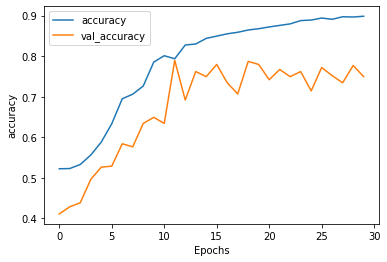

In [9]:
plot_graphs(history,"accuracy");

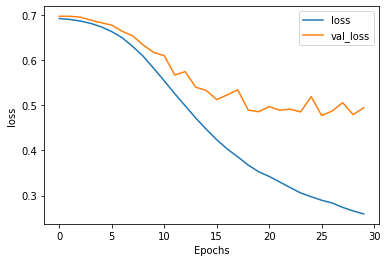

In [10]:
plot_graphs(history,'loss')

# Get files for visualazing the network

In [11]:
# First get the weights of the embedding layer
e = model.layers[0]

weights = e.get_weights()[0]

print(weights.shape) 

(500, 16)


In [12]:
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

# Download files to use on `project tensorflow`

In [ ]:
# Download the files
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

# Lets now predict some fake reviews

In [13]:
# Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

I love this phone
[0.90706974]


I hate spaghetti
[0.16385315]


Everything was cold
[0.5970172]


Everything was hot exactly as I wanted
[0.41793182]


Everything was green
[0.5970172]


the host seated us immediately
[0.577844]


they gave us free chocolate cake
[0.8593742]


not sure about the wilted flowers on the table
[0.08541786]


only works when I stand on tippy toes
[0.8621705]


does not work when I stand on my head
[0.03621165]


